## Pipeline to screen phenotype strength of a target feature in various datasets
* this pipeline is for screening per site values of the target feature versus control wells for a given dataset

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.preprocessing as sp
import pickle
import matplotlib.pyplot as plt
import scipy
import os
import time
from datetime import date
today = date.today()

import sys
# sys.path.insert(0, '/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
sys.path.insert(0, '/home/jupyter-mhaghigh@broadinst-ee45a/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
from singlecell.read import read_single_cell_sql
from singlecell.preprocess import handle_nans, extract_cpfeature_names,find_highly_correlated_features
from singlecell.visualize import visualize_n_SingleCell
from singlecell.process import statistical_tests,precision_recall
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter
from singlecell.save.save_pandas_dfs import saveDF_to_CSV_GZ_no_timestamp, saveAsNewSheetToExistingFile
from singlecell.preprocess.control_for_cellcount import control_feature_y_for_variable_x
from singlecell.process import normalize_funcs
from singlecell.process import bbf_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload





# Steps:

### 1. Form a list of orthogonal features to target feature based on per well aggregated profiles
   - Read per well csv profiles and form a df for all plates
   - The selected set of features have <0.1 correlation with the target feature according to the target dataset.
   - Save the list as a pickle file
     - Output Folder on s3: <font color='blue'>projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/target_orth_features_lists</font> 

### 2. Create per site aggregate level of data for a few features
   - Read saved orthogonal to target feature list which is derived from step 1
   - Read the set of orth+target features from each plate and form per site measures
   - Concat and save it in output folder
     - Output Folder on s3: <font color='blue'>projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/per_site_aggregated_profiles</font> 

### 3. Load per_site aggregated data and control target feature for cell counts
  - Read the saved aggregated per site level data
  - PER PLATE control of target feature for cell count
  - PER PLATE low variance feature removal
  
   
### 4. Apply PER PLATE statistical test between the target feature values for each pert versus controls 
- And the same for orth features
- We calculate test stats per plate and take the p and t values of the plate with median t value
    - Output Folder on s3: <font color='blue'>projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/reverse_phenotype_strength</font> 


In [6]:
############################################################################################
# This list contains features which their phenotype strength were significantly different across 
# various categories in the patient fibroblast data and were available in at least one of the 
# three datasets examined here

# target_features_list_orf_cdrp=['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16',\
#              'Nuclei_Texture_DifferenceVariance_Mito_10_00_256',\
#              'Nuclei_Texture_Contrast_Mito_10_00_256']

target_features_list_orf_cdrp=['slope']
target_features_list_lincs=['slope']
# target_features_list_lincs=['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16']

########################## Project root directory and path to results ########################
# home_path="/home/ubuntu/" # ec2
home_path="/home/jupyter-mhaghigh@broadinst-ee45a/" #dgx
mito_project_root_dir=home_path+"bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/"
save_results_dir=mito_project_root_dir+"/workspace/results/"

In [6]:
# python3 ~/imaging-backup-scripts/restore_intelligent.py

In [ ]:
https://imaging-platform.s3.amazonaws.com/projects/2018_04_20_Rosetta/workspace/preprocessed_data

### Set dataset specific parameters

In [7]:
lincs_meta_cols=['Metadata_broad_sample','Metadata_dose_recode','Metadata_pert_id','Metadata_pert_mfc_id',\
'Metadata_InChIKey14','Metadata_pert_type','Metadata_moa','Metadata_target','Metadata_pert_id_dose','Metadata_pert_name']

# lincs_meta_cols=['Metadata_broad_sample','Metadata_dose_recode','Metadata_pert_id','Metadata_pert_mfc_id',\
# 'Metadata_InChIKey14','Metadata_pert_type','Metadata_pert_id_dose']

cdrp_meta_cols=['Metadata_broad_sample','Metadata_mmoles_per_liter2','Metadata_pert_id','Metadata_Sample_Dose','Metadata_moa']
jumporf_meta_cols=['Metadata_Symbol','Metadata_broad_sample','Metadata_JCP2022']
jumpcrispr_meta_cols=['Metadata_NCBI_Gene_ID','Metadata_Symbol','Metadata_JCP2022']
jumpcompound_meta_cols=['Metadata_InChIKey','Metadata_InChI','Metadata_JCP2022']
taorf_meta_cols=['Metadata_gene_name','Metadata_pert_name','Metadata_broad_sample','Metadata_moa']


                 
jump_orf_params={'profiles_path':home_path+"/gallery/cpg0016-jump/source_4/workspace/backend/",\
                 'meta_cols':jumporf_meta_cols,\
                 'pert_col':'Metadata_JCP2022',\
                 'target_features_list':target_features_list_orf_cdrp
                }    
    
cdrp_params={'profiles_path':home_path+"/gallery/cpg0012-wawer-bioactivecompoundprofiling/broad/workspace/backend/",\
             'meta_cols':cdrp_meta_cols,\
             'pert_col':'Metadata_Sample_Dose',\
             'target_features_list':target_features_list_orf_cdrp             
                }
             
lincs_params={'profiles_path':home_path+'/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/backend/',\
             'meta_cols':lincs_meta_cols,\
             'pert_col':'Metadata_pert_id_dose',\
             'target_features_list':target_features_list_lincs              
                }

jump_crispr_params={'profiles_path':home_path+"/gallery/cpg0016-jump/source_13/workspace/backend/",\
                 'meta_cols':jumpcrispr_meta_cols,\
                 'pert_col':'Metadata_JCP2022',\
                 'target_features_list':target_features_list_orf_cdrp
                }

jump_compound_params={'profiles_path':home_path+"/gallery/cpg0016-jump/source_13/workspace/backend/",\
                 'meta_cols':jumpcompound_meta_cols,\
                 'pert_col':'Metadata_JCP2022',\
                 'target_features_list':target_features_list_orf_cdrp
                }

ta_orf_params={'profiles_path':home_path+"/gallery/cpg0017-rohban-pathways/broad/workspace/backend/",\
                 'meta_cols':taorf_meta_cols,\
                 'pert_col':'Metadata_broad_sample',\
                 'target_features_list':target_features_list_orf_cdrp
                }

ds_info_dict={'jump_orf':jump_orf_params,\
              'CDRP':cdrp_params,\
              'lincs':lincs_params,\
              'jump_crispr':jump_crispr_params,\
              'jump_compound':jump_compound_params,\
              'taorf':ta_orf_params}


In [4]:
ls ~/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/results/virtual_screen/

CDRP_results_pattern_1.csv*
CDRP_results_pattern_2.csv*
CDRP_results_pattern_aug_070624.csv*
CDRP_results_pattern_aug_2.csv*
CDRP_results_pattern_aug.csv*
jump_compound_results_pattern_aug_070624.csv*
jump_crispr_results_pattern_2.csv*
jump_crispr_results_pattern_aug_070624.csv*
jump_crispr_results_pattern_aug_2.csv*
jump_crispr_results_pattern_aug_allbatches.csv*
jump_crispr_results_pattern_aug.csv*
jump_orf_results_pattern_1.csv*
jump_orf_results_pattern_2.csv*
jump_orf_results_pattern_aug_070624.csv*
jump_orf_results_pattern_aug_2.csv*
jump_orf_results_pattern_aug.csv*
lincs_results_pattern_1.csv*
lincs_results_pattern_2.csv*
lincs_results_pattern_aug_070624.csv*
lincs_results_pattern_aug_2.csv*
lincs_results_pattern_aug.csv*
taorf_results_pattern_1.csv*
taorf_results_pattern_2.csv*
taorf_results_pattern_aug_070624.csv*
taorf_results_pattern_aug_2.csv*
taorf_results_pattern_aug.csv*


## Filter list to significant perturbations and check scatter plot of t-values
- the pearson,mudholkar_george,fisher tests for combining p-values give kind of binary results 
- I decided to use the absolute average values
    - 1- The mean absolute t-values gives evidence for the strength of the difference
    - 2- The mean p-values give evidence for the confidence of the difference
  
- Therefor, we care about the 1 first of all and then for the ones that has passed filter one keep the ones
  which have high confidence (we can totally ignore mean ps because basically it is saying that for the ones that 
  show to be close to the control we may see some in average small p-values? But what does that mean? If mean absolute t-value is small, p-values should be large to, right? why this doesnt hold) 

In [14]:
root_res_dir=mito_project_root_dir+\
"workspace/"
fName="phenotype_strength_Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16_4.csv"
# target_feat="Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16"
target_feat='slope'
# target_feats_list=['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16',\
#              'Nuclei_Texture_DifferenceVariance_Mito_10_00_256',\
#              'Nuclei_Texture_Contrast_Mito_10_00_256']

# write_res_path=root_res_dir+'/results/reverse_phenotype_strength/'
write_res_path=root_res_dir+'/results/virtual_screen/'


add_columns_to_print=['Count_Cells_avg','p_target_pattern', 'p_orth', 'p_slope',\
       'p_slope_std', 'p_pattern_std', 'p_orth_std', 't_target_pattern',\
       't_orth', 't_slope', 'd_slope', 'last_peak_ind', 'slope']


sort_by_col="d_slope"
p_val_target_col="p_slope_std";#p_pattern_std, p_slope_std, p_pattern_std
p_val_orth_col="p_orth_std";#p_orth_std

# def bh_adjusted_pvalues(pvalues, fdr=0.05):
#     sorted_pvalues = pvalues.sort_values()
#     m = len(pvalues)
#     ranks = np.arange(1, m+1)
#     critical_values = (ranks / m) * fdr
#     max_pvalue = sorted_pvalues[sorted_pvalues <= critical_values].max()
#     return max_pvalue


def bh_adjusted_critical_value(pvalues, fdr=0.05):
    sorted_pvalues = np.sort(pvalues)
    m = len(pvalues)
    ranks = np.arange(1, m + 1)
    critical_values = (ranks / m) * fdr
    below_threshold = sorted_pvalues <= critical_values
    if np.any(below_threshold):
        adjusted_critical = sorted_pvalues[below_threshold].max()
    else:
        adjusted_critical = np.nan  # Or an appropriate value if no p-values are below the threshold
    return adjusted_critical


# dataset='CDRP';dataset_meta_hue='Metadata_moa'
# dataset='lincs';dataset_meta_hue='Metadata_moa'
# dataset='jump_orf';dataset_meta_hue='Symbol'
# CDRP/  jump_orf/  lincs/

list_of_res_df={}
list_of_res_df1={}
list_of_res_df2={}

orth_bh_corrected_critical_dict={}
target_bh_corrected_critical_dict={}

filtering_stats=pd.DataFrame(columns=['raw','target feature significance','orth filter','both filters'])
for dataset,dataset_meta_hue in zip(['taorf','lincs','CDRP','jump_orf','jump_crispr','jump_compound'],\
                     ['Metadata_moa','Metadata_moa','Metadata_moa','Metadata_Symbol','Metadata_Symbol','Metadata_Symbol']):
# for dataset,dataset_meta_hue in zip(['lincs','CDRP','jump_orf'],\
#                                               ['Metadata_moa','Metadata_moa','Symbol']):

# for dataset,dataset_meta_hue in zip(['lincs','jump_orf'],\
#                                               ['Metadata_moa','Symbol']):
#     filtering_stats['dataset']=dataset

    meta_cols=ds_info_dict[dataset]["meta_cols"]
    pert_col=ds_info_dict[dataset]["pert_col"]
    
#     res_df=pd.read_csv(root_res_dir+'per_site_aggregated_profiles/'+dataset+'/'+fName)
#     res_df=pd.read_csv(write_res_path+"/"+dataset+"_results_pattern_aug_2.csv")
    res_df=pd.read_csv(write_res_path+"/"+dataset+"_results_pattern_aug_070624.csv")

    print('null size',res_df[res_df["t_orth"].isnull()].reset_index(drop=True).shape)
    uncorr_feats_condese=pd.read_csv(save_results_dir+'target_pattern_orth_features_lists/fibroblast_derived.csv')['orth_fs'].tolist()
#     uncorr_feats_condese=pd.read_csv(save_results_dir+'target_pattern_orth_features_lists/'+dataset+'.csv')['orth_fs'].tolist()
#     fsdfsadfs
#     t_feats_diff_control=['t_'+f for f in uncorr_feats_condese]
#     p_feats_diff_control=['p_'+f for f in uncorr_feats_condese]
    
    if 0:
        plt.figure()
        plt.scatter(res_df["Count_Cells_avg"],res_df["slope"])
        plt.title(dataset)
    
    # t_feats=res_df.columns[res_df.columns.str.contains("t_Cells_|t_Nuclei_|t_Cytoplasm_")].tolist()
    
#     t_feats=res_df.columns[res_df.columns.str.startswith("t_")].tolist()
#     t_feats_diff_control=t_feats.copy()

#     for target_f in target_feats_list:
#         try:
#             t_feats_diff_control.remove("t_"+target_f)
#             t_feats_diff_control.remove("t_"+target_f+"_ccOut")
            
#         except ValueError:
#             pass

#     p_feats_diff_control=['p'+f[1:] for f in t_feats_diff_control]
    
    
#     print('n_nulls',res_df[res_df["t_"+target_feat].isnull()].shape[0])


    res_df=res_df[~res_df[sort_by_col].isnull()].reset_index(drop=True)
    filtering_stats.loc[dataset,'raw']=res_df.shape[0]
    
    n_perts=res_df[pert_col].unique().shape[0]

#     res_df.to_csv(write_res_path+dataset+'.csv',index=False)
    if 0:
        res_df.sort_values(by=sort_by_col).to_csv(root_res_dir+'/results/virtual_screen_not_filtered/'+\
                                                   dataset+'_raw_070624.csv',index=False)
    

    list_of_res_df[dataset]=res_df
    if 0:
        res_df[['p_orth','t_orth','Count_Cells_avg']].hist(bins=100,figsize=(10,5))
    
    if 1:
        res_df_hcc=res_df.copy()
    else:
        res_df_hcc=res_df[res_df['Count_Cells_avg']>res_df['Count_Cells_avg'].quantile(.1)].\
            reset_index(drop=True)

#     standard_critical_value=0.05
#     corrected_critical=0.05/n_perts
    
    corrected_critical = np.round(bh_adjusted_critical_value(res_df_hcc[p_val_target_col], fdr=0.05),5)
    orth_bh_corrected_critical = np.round(bh_adjusted_critical_value(res_df_hcc[p_val_orth_col], fdr=0.05),5)

    
    
    
    orth_bh_corrected_critical_dict[dataset] = orth_bh_corrected_critical
    target_bh_corrected_critical_dict[dataset] = corrected_critical
    print(dataset,'orth_bh_corrected_critical',orth_bh_corrected_critical)
#     print(corrected_critical,0.05/n_perts)    
    

    if 1:
        res_df_target_sig0=res_df_hcc[(res_df_hcc[p_val_target_col]<corrected_critical)].reset_index(drop=True)
        print(res_df_target_sig0.shape[0])
        filtering_stats.loc[dataset,'target feature significance']=res_df_target_sig0.shape[0]
    else:
        res_df_target_sig0=res_df.copy()        

    filtering_stats.loc[dataset,'orth filter']=res_df_hcc[(res_df_hcc[p_val_orth_col]>orth_bh_corrected_critical)].shape[0]
    
    list_of_cols_2save = [pert_col]+[sort_by_col, p_val_target_col, p_val_orth_col,'t_orth',\
                                                'Count_Cells_avg']+ meta_cols    
    
    
    if 1:
        res_df_target_sig0=res_df_target_sig0[(res_df_target_sig0[p_val_orth_col]>orth_bh_corrected_critical)].reset_index(drop=True)
        res_df_target_orth_filt=res_df_hcc[(res_df_hcc[p_val_orth_col]>orth_bh_corrected_critical)].\
        reset_index(drop=True).sort_values(by=sort_by_col)[list_of_cols_2save]
        res_df_target_orth_filt=res_df_target_orth_filt.loc[:, ~res_df_target_orth_filt.columns.duplicated(keep='last')]
        
        
        
        filtering_stats.loc[dataset,'both filters']=res_df_target_sig0.shape[0]
   
    
    res_df1=res_df_target_sig0.copy()
    res_df.loc[res_df[pert_col].isin(res_df1[pert_col].unique()),'status']='significant'
    res_df_2save=res_df.sort_values(by=sort_by_col)[list_of_cols_2save]
    res_df_2save = res_df_2save.loc[:, ~res_df_2save.columns.duplicated(keep='last')]
    
    res_df_2save_filt=res_df1.sort_values(by=sort_by_col)[list_of_cols_2save]
    res_df_2save_filt = res_df_2save_filt.loc[:, ~res_df_2save_filt.columns.duplicated(keep='last')]
    

    
    
    if 0:
        saveAsNewSheetToExistingFile(root_res_dir+'/results/virtual_screen_results_202407/'+dataset+'_screen_results.xlsx',\
                                 [res_df_2save,res_df_target_orth_filt,res_df_2save_filt],\
                                 [dataset, dataset+'_orthfilt',dataset+'_bothfilt'] ,keep_index_column=False)
        
         
    

    list_of_res_df1[dataset]=res_df_target_orth_filt
    list_of_res_df2[dataset]=res_df_2save_filt
#     res_df2=res_df[(res_df['p_abs_avg_orth_features']>0.2) & (res_df['p_'+target_feat]<0.001)].reset_index(drop=True)
#     print(dataset,res_df1.shape,res_df[(res_df['p_orth']>standard_critical_value)].shape,res_df.shape)
    print(dataset,": original shape: ",res_df.shape,"   filtered shape:",res_df1.shape)
    
#     list_of_res_df2.append(res_df2[meta_cols+add_columns_to_print])
    
#     sfdsfsd

null size (4, 17)
taorf orth_bh_corrected_critical 0.03558
32
taorf : original shape:  (323, 18)    filtered shape: (3, 17)
null size (1, 23)
lincs orth_bh_corrected_critical 0.04829
1432
lincs : original shape:  (9394, 24)    filtered shape: (12, 23)
null size (1, 18)
CDRP orth_bh_corrected_critical 0.0483
5658
CDRP : original shape:  (30618, 19)    filtered shape: (143, 18)
null size (345, 16)
jump_orf orth_bh_corrected_critical 0.03828
587
jump_orf : original shape:  (14787, 17)    filtered shape: (60, 16)
null size (2, 16)
jump_crispr orth_bh_corrected_critical 0.04785
1117
jump_crispr : original shape:  (7975, 17)    filtered shape: (3, 16)
null size (2, 16)
jump_compound orth_bh_corrected_critical 0.04756
8457
jump_compound : original shape:  (115729, 17)    filtered shape: (229, 16)


In [13]:
target_bh_corrected_critical_dict

{'taorf': 0.00409,
 'lincs': 0.00761,
 'CDRP': 0.00924,
 'jump_orf': 0.00198,
 'jump_crispr': 0.007,
 'jump_compound': 0.00365}

In [15]:
orth_bh_corrected_critical_dict

{'taorf': 0.03558,
 'lincs': 0.04829,
 'CDRP': 0.0483,
 'jump_orf': 0.03828,
 'jump_crispr': 0.04785,
 'jump_compound': 0.04756}

In [17]:
print(len(set(list_of_res_df['taorf']['Metadata_gene_name'])))
print(len(set(list_of_res_df['jump_orf']['Metadata_Symbol'])))
print(len(set(list_of_res_df['taorf']['Metadata_gene_name']) & set(list_of_res_df['jump_orf']['Metadata_Symbol'])))

190
12347
154


In [47]:
# res_df_target_sig0
# res_df
orth_bh_corrected_critical_dict

{'taorf': 0.0328682154922577,
 'lincs': 0.0482929972989429,
 'CDRP': 0.0481242427803521,
 'jump_orf': 0.0375156321477045,
 'jump_crispr': 0.0478530069113243}

In [17]:
orth_bh_corrected_critical_dict

{'taorf': 0.0328682154922577,
 'lincs': 0.0482929972989429,
 'CDRP': 0.0481242427803521,
 'jump_orf': 0.0375156321477045,
 'jump_crispr': 0.0478530069113243,
 'jump_compound': 0.0474630677339327}

In [33]:
# corrected_critval
df=list_of_res_df[0]
df.loc[df["Metadata_gene_name"].isin(['GSK3B','GSK3A','CACNA1C']),["Metadata_gene_name",\
                                            "Metadata_pert_name","p_"+target_feat+'_ccOut',"p_"+target_feat]]

,Metadata_gene_name,Metadata_pert_name,p_Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16_ccOut,p_Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16
113,GSK3B,GSK3B_WT.2,0.074459,0.144564
217,GSK3B,GSK3B_WT.1,0.923710,0.759843


In [91]:
# res_df_target_sig[(res_df_target_sig['t_'+target_feat].abs()/res_df_target_sig['t_abs_avg_orth_features'].abs())>2]

In [81]:
res_df_target_sig['t_'+target_feat].abs().min()

7.371796473864218

In [ ]:
plt.figure()
plt.scatter(res_df["t_abs_avg_orth_features"],res_df["p_abs_avg_orth_features"])

<IPython.core.display.Javascript object>


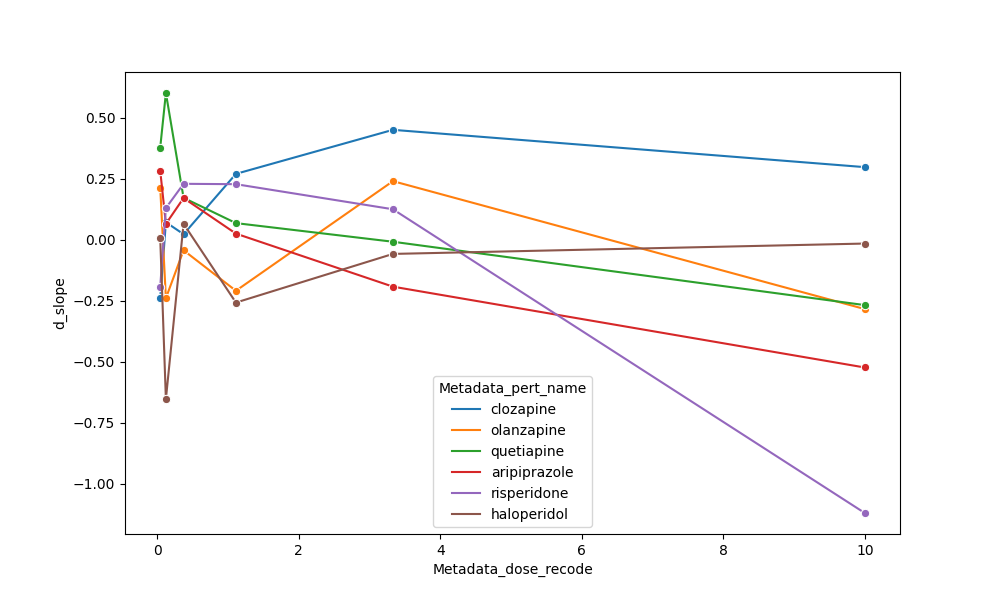

In [114]:
res_df_lincs=list_of_res_df['lincs']
list_tested_by_matt=['clozapine','haloperidol','aripiprazole','olanzapine','quetiapine','risperidone']
df_tested_matt=res_df_lincs[res_df_lincs['Metadata_pert_name'].isin(list_tested_by_matt)];
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_tested_matt, x='Metadata_dose_recode', y='d_slope', hue='Metadata_pert_name',marker='o')
plt.show()

<IPython.core.display.Javascript object>


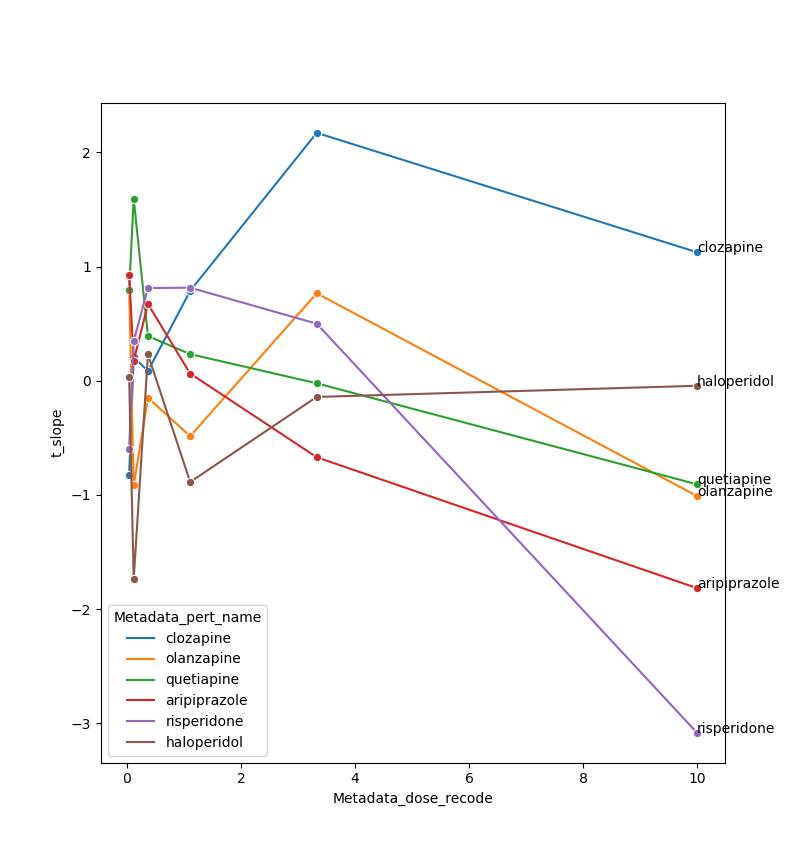

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming res_df_lincs and list_tested_by_matt are defined
list_tested_by_matt = ['clozapine', 'haloperidol', 'aripiprazole', 'olanzapine', 'quetiapine', 'risperidone']
df_tested_matt = res_df_lincs[res_df_lincs['Metadata_pert_name'].isin(list_tested_by_matt)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_tested_matt, x='Metadata_dose_recode', y='t_slope', hue='Metadata_pert_name', marker='o')

# Adding labels next to the last points of each line
for name, group in df_tested_matt.groupby('Metadata_pert_name'):
    last_point = group.sort_values(by='Metadata_dose_recode').iloc[-1]
    plt.text(last_point['Metadata_dose_recode'], last_point['t_slope'], name, horizontalalignment='left')

plt.show()



In [57]:
df_tested_matt[['p_pattern_std','p_slope_std','p_slope','Metadata_pert_name','Metadata_dose_recode']].sort_values(by='p_slope')

,p_pattern_std,p_slope_std,p_slope,Metadata_pert_name,Metadata_dose_recode
6966,2.220446e-16,0.001647,0.013829,risperidone,10.00
550,1.046981e-05,0.028256,0.054813,clozapine,3.33
4968,0.000000e+00,0.067326,0.102803,aripiprazole,10.00
6389,1.842267e-04,0.080444,0.118294,haloperidol,0.12
2236,1.252495e-02,0.109256,0.147539,quetiapine,0.12
625,1.465109e-02,0.259054,0.288910,clozapine,10.00
5284,4.249629e-06,0.311707,0.339078,olanzapine,10.00
3271,2.150932e-02,0.351726,0.377247,aripiprazole,0.04
5238,0.000000e+00,0.358388,0.382634,olanzapine,0.12
5998,1.176836e-14,0.363416,0.388128,quetiapine,10.00
